# Analyzing RCT with Precision by Adjusting for Baseline Covariates

# Jonathan Roth's DGP

Here we set up a DGP with heterogenous effects. In this example, with is due to Jonathan Roth, we have
$$
E [Y(0) | Z] = - Z, \quad E [Y(1) |Z] = Z, \quad Z \sim N(0,1).
$$
The CATE is
$$
E [Y(1) - Y(0) | Z ]= 2 Z.
$$
and the ATE is
$$
2 E Z = 0.
$$

We would like to estimate ATE as precisely as possible.

An economic motivation for this example could be provided as follows: Let D be the treatment of going to college, and $Z$ academic skills.  Suppose that academic skills cause lower earnings Y(0) in jobs that don't require college degree, and cause higher earnings  Y(1) in jobs that require college degrees. This type of scenario is reflected in the DGP set-up above.



In [218]:
# import Pkg; Pkg.add("Distributions")
# import Pkg; Pkg.add("Tables")
# import Pkg; Pkg.add("TableOperations")
# import Pkg; Pkg.add("StatsBase")
# import Pkg; Pkg.add("FreqTables")
# import Pkg; Pkg.add("Plots")

In [145]:
# Import relevant packages for splitting data
using LinearAlgebra, GLM, DataFrames, Statistics, Random, Distributions, Tables, TableOperations, StatsBase, FreqTables, DataFrames

In [146]:
# Set Seed
# to make the results replicable (generating random numbers)
Random.seed!(12345676)     # set MC seed

n = 1000                # sample size
Z = randn(n, 1)         # generate Z
Y0 = -Z + randn(n, 1)   # conditional average baseline response is -Z
Y1 = Z + randn(n, 1)    # conditional average treatment effect is +Z
D = Int.(rand(Uniform(), n, 1) .< 0.2)   # treatment indicator; only 23% get treated
length(D[D .== 1])*100/length(D[D .== 0])  # treatment indicator; only 23% get treated
mean(D)

0.189

In [147]:
# column = rand(5);

# DataFrame([column], [:col1])

In [182]:
Y = (Y1.*D) + (Y0.*(ones(n,1)-D))    # observed Y
D = D - fill(mean(D),n,1)            # demean D
Z = Z - fill(mean(Z),n,1)            # demean Z

1000×1 Matrix{Float64}:
  1.726930592166616
  2.6668920923293324
  0.17260327143465098
  0.22981794818549167
  1.466898001424473
  1.3529320088626253
  0.1863114143889225
  0.04369619043375853
 -0.5850402073066382
 -0.0643490070645289
 -1.10936088593052
 -0.8286904334211317
 -1.916406193712996
  ⋮
 -1.1865268777224587
 -0.3632408555708126
  0.7893783341581972
  2.875748293624403
  0.8344513543325733
  1.0072571424293475
  0.4003202863359305
 -0.6043502214480204
  0.09863327796173031
 -2.45008621581788
 -1.8543324535087402
 -0.48790168982563364

# Analyze the RCT data with Precision Adjustment

Consider 

*  classical 2-sample approach, no adjustment (CL)
*  classical linear regression adjustment (CRA)
*  interactive regression adjusment (IRA)

Carry out inference using robust inference, using the sandwich formulas (Eicker-Huber-White).  

Observe that CRA delivers estimates that are less efficient than CL (pointed out by Freedman), whereas IRA delivers more efficient approach (pointed out by Lin). In order for CRA to be more efficient than CL, we need the CRA to be a correct model of the conditional expectation function of Y given D and X, which is not the case here.

In [173]:
Z_times_D = Z.*D
X = hcat(D, Z, Z_times_D)
data = DataFrame(X, [:Z, :D, :Z_times_D])

,Z,D,Z_times_D
,Float64,Float64,Float64
1,-0.189,1.72693,-0.32639
2,0.811,2.66689,2.16285
3,-0.189,0.172603,-0.032622
4,-0.189,0.229818,-0.0434356
5,-0.189,1.4669,-0.277244
6,-0.189,1.35293,-0.255704
7,-0.189,0.186311,-0.0352129
8,-0.189,0.0436962,-0.00825858
9,-0.189,-0.58504,0.110573


In [220]:
# Import packages for OLS regression
using GLM, Plots

In [207]:
data_aux = [Y D Z Z_times_D]
data_aux = DataFrame(data_aux, [:Y, :D, :Z, :Z_times_D])

,Y,D,Z,Z_times_D
,Float64,Float64,Float64,Float64
1,-1.57126,-0.189,1.72693,-0.32639
2,1.53851,0.811,2.66689,2.16285
3,-0.552237,-0.189,0.172603,-0.032622
4,0.241576,-0.189,0.229818,-0.0434356
5,-2.71474,-0.189,1.4669,-0.277244
6,-0.955155,-0.189,1.35293,-0.255704
7,-0.0891579,-0.189,0.186311,-0.0352129
8,-2.38482,-0.189,0.0436962,-0.00825858
9,2.28832,-0.189,-0.58504,0.110573


In [208]:
fm_1 = @formula(Y ~ D)
fm_2 = @formula(Y ~ D + Z)
fm_3 = @formula(Y ~ D + Z + Z_times_D)

FormulaTerm
Response:
  Y(unknown)
Predictors:
  D(unknown)
  Z(unknown)
  Z_times_D(unknown)

In [214]:
CL_model = lm(fm_1, data_aux)
CRA_model = lm(fm_2, data_aux)  #classical
IRA_model = lm(fm_3, data_aux)  #interactive approach
@show CL_model
@show CRA_model
@show IRA_model

CL_model = StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Y ~ 1 + D

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error     t  Pr(>|t|)   Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  0.0450644   0.0555981  0.81    0.4178  -0.0640381   0.154167
D            0.0593067   0.14201    0.42    0.6763  -0.219366    0.337979
─────────────────────────────────────────────────────────────────────────
CRA_model = StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Y ~ 1 + D + Z

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error       t  Pr(>|t|)   Lower 95%  Upper 9

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Y ~ 1 + D + Z + Z_times_D

Coefficients:
───────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)   0.0278515   0.0362395    0.77    0.4423  -0.043263   0.098966
D             0.0471567   0.0926216    0.51    0.6108  -0.134599   0.228913
Z            -1.01934     0.0350665  -29.07    <1e-99  -1.08815   -0.950523
Z_times_D     1.98389     0.0920421   21.55    <1e-84   1.80327    2.16451
───────────────────────────────────────────────────────────────────────────

In [246]:
# Comparing models
ftest(CL_model.model, CRA_model.model, IRA_model.model)

F-test: 3 models fitted on 1000 observations
───────────────────────────────────────────────────────────────────────
     DOF  ΔDOF        SSR        ΔSSR      R²     ΔR²        F*   p(>F)
───────────────────────────────────────────────────────────────────────
[1]    3        3084.9642              0.0002                          
[2]    4     1  1917.2505  -1167.7137  0.3786  0.3785  607.2293  <1e-99
[3]    5     1  1307.4120   -609.8385  0.5763  0.1976  464.5813  <1e-84
───────────────────────────────────────────────────────────────────────

In [268]:
# Standard deviations for estimators
CL = sqrt(sum((Y - predict(CL_model)).*(Y - predict(CL_model)))./length(Y))
CRA = sqrt(sum((Y - predict(CRA_model)).*(Y - predict(CRA_model)))./length(Y))
IRA = sqrt(sum((Y - predict(IRA_model)).*(Y - predict(IRA_model)))./length(Y))
@show CL
@show CRA
@show IRA

CL = 1.7564066279325194
CRA = 1.3846481535483826
IRA = 1.1434211887694885


1.1434211887694885

In [278]:
# Check t values of regressors 
@show coeftable(CL_model).cols[4]
@show coeftable(CRA_model).cols[4]
@show coeftable(IRA_model).cols[4]

(coeftable(CL_model)).cols[4] = [0.41782338381116035, 0.6763122421522593]
(coeftable(CRA_model)).cols[4] = [0.3043671673148393, 0.29054696200357666, 4.334610690849673e-105]
(coeftable(IRA_model)).cols[4] = [0.4423490653757651, 0.6107715088805379, 5.1192582434572607e-135, 7.0769019608122e-85]


4-element Vector{Float64}:
 0.4423490653757651
 0.6107715088805379
 5.1192582434572607e-135
 7.0769019608122e-85

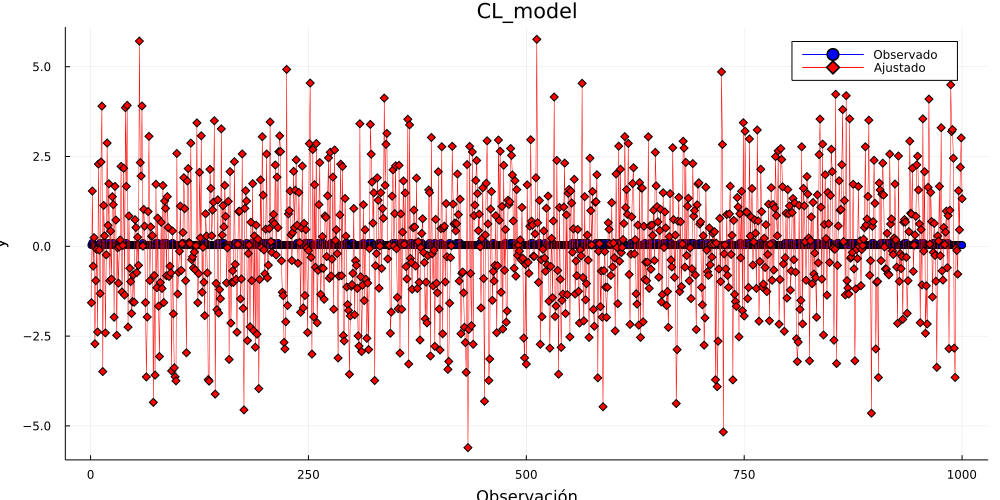

In [299]:
linearFit = predict(CL_model)
plt_yhat = plot([linearFit Y], xlabel="Observación", ylabel = "y", title = "CL_model", 
                  color=[:blue :red], label=["Observado" "Ajustado"], legend = true, 
                  linewidth = 0.5, shape = [:circle :diamond], grid = true)
plot!(size=(1000,500))
display(plt_yhat)

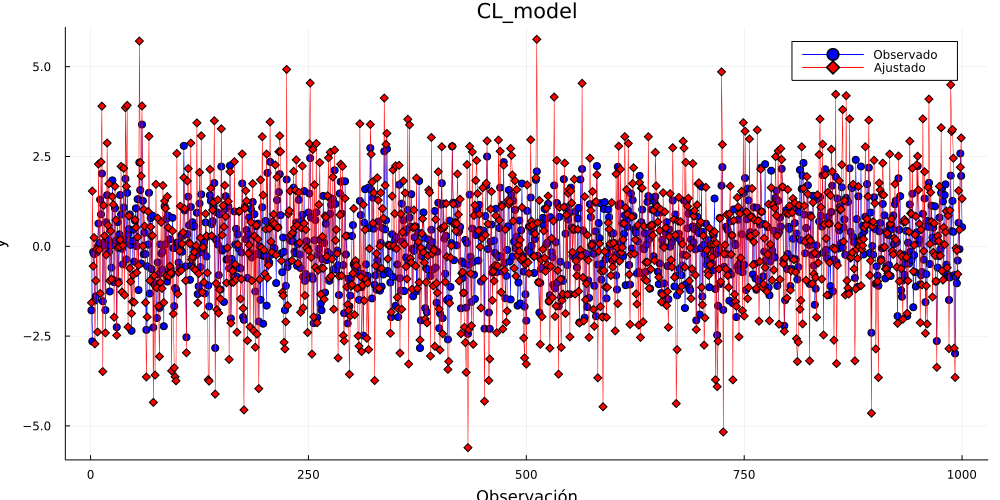

In [301]:
linearFit = predict(CRA_model)
plt_yhat = plot([linearFit Y], xlabel="Observación", ylabel = "y", title = "CL_model", 
                  color=[:blue :red], label=["Observado" "Ajustado"], legend = true, 
                  linewidth = 0.5, shape = [:circle :diamond], grid = true)
plot!(size=(1000,500))
display(plt_yhat)

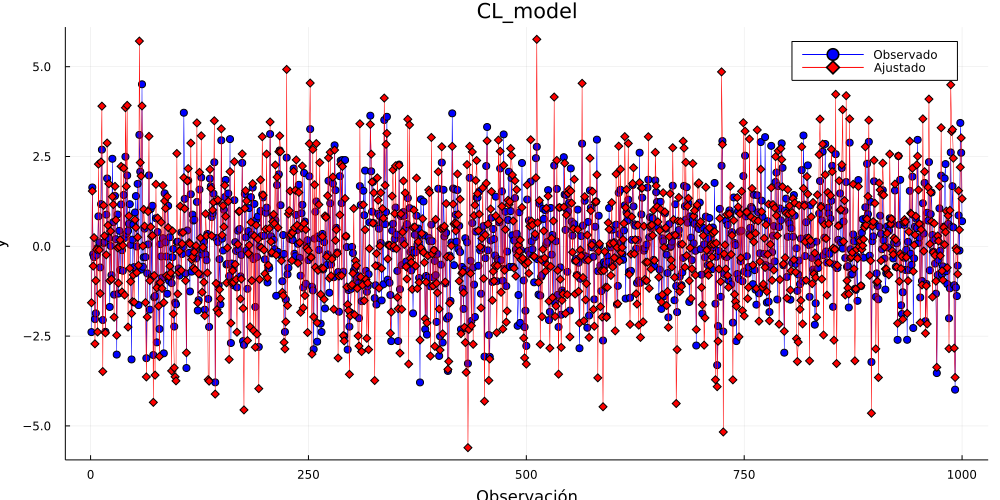

In [302]:
linearFit = predict(IRA_model)
plt_yhat = plot([linearFit Y], xlabel="Observación", ylabel = "y", title = "CL_model", 
                  color=[:blue :red], label=["Observado" "Ajustado"], legend = true, 
                  linewidth = 0.5, shape = [:circle :diamond], grid = true)
plot!(size=(1000,500))
display(plt_yhat)

# Verify Asymptotic Approximations Hold in Finite-Sample Simulation Experiment

In [348]:
Random.seed!(12345676)     # set MC seed
n = 1000
B = 1000

# format of data = float32
CLs = fill(0., B)
CRAs = fill(0., B)
IRAs = fill(0., B)


# formulas for regressions
fm_1 = @formula(Y ~ D)
fm_2 = @formula(Y ~ D + Z)
fm_3 = @formula(Y ~ D + Z + Z_times_D)

# models
CL_model = lm(fm_1, data_aux)
CRA_model = lm(fm_2, data_aux)  #classical
IRA_model = lm(fm_3, data_aux)  #interactive approach


# simulation
for i in 1:B
    Z = randn(n, 1)         # generate Z
    Y0 = -Z + randn(n, 1)   # conditional average baseline response is -Z
    Y1 = Z + randn(n, 1)    # conditional average treatment effect is +Z
    D = Int.(rand(Uniform(), n, 1) .< 0.2)   # treatment indicator; only 23% get treated

    Y = (Y1.*D) + (Y0.*(ones(n,1)-D))    # observed Y

    D = D - fill(mean(D),n,1)            # demean D
    Z = Z - fill(mean(Z),n,1)            # demean Z

    Z_times_D = Z.*D
    X = hcat(D, Z, Z_times_D)
    data_aux = [Y D Z Z_times_D]
    data_aux = DataFrame(data_aux, [:Y, :D, :Z, :Z_times_D])
    
    CLs[i,] = predict(CL_model)[i]
    CRAs[i,] = predict(CRA_model)[i]
    IRAs[i,] = predict(IRA_model)[i]

end


# check  standard deviations
println("Standard deviations for estimators")  
println("CL model: " , sqrt(sum((Y - predict(CL_model)).*(Y - predict(CL_model)))./length(Y)))
println("CRA model: " , sqrt(sum((Y - predict(CL_model)).*(Y - predict(CRA_model)))./length(Y)))
println("IRA model: " , sqrt(sum((Y - predict(CL_model)).*(Y - predict(IRA_model)))./length(Y)))

Standard deviations for estimators
CL model: 1.4545726198637772
CRA model: 1.3097621564719322
IRA model: 1.0235301183486727
